### Tuning hyper-paremter of BG cell classifier

In [1]:
# Importing libraries
import sys
sys.path.insert(0,
                '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/')

from constants import * 
from base import *
from custom_metrics import *
from tuning_cv import *

In [2]:
## Importing libraries 
import pandas as pd
import numpy as np 


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

### Importing data 

In [3]:
# Annotated cells 
cell_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/cells/"
cell_training = "training.txt"

# NNB information of all cells on slide
nnb_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/NNB/"
nnb_training = "training_NNB.txt"

# hema nucleus of all cells on slide
hema_path = "/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Training_data/BG/hema/"
hema_training = "training_hema.txt"

Require: 
1. input_files.txt - to contian filenames I want to use. ** currently .csv files

In [4]:
# Importing annotated cells 

# obtaining list of files 
with open(cell_path + cell_training) as f: 
    mylist= f.read().splitlines()
    
print("Read in: ",len(mylist),"files")

# reading in all those files 
inputs = [] 
for i in mylist: 
    dat_ = pd.read_csv(cell_path + i,sep=",")
    dat_.columns.values[5] = 'Centroid_X'
    dat_.columns.values[6] = 'Centroid_Y'
    dat = dat_[cell_extracted_features] # fixed extracted feature order
    inputs.append(dat)
print("Extracted:", len(inputs),"files")


Read in:  20 files
Extracted: 20 files


In [5]:
# Importing in neghbouring cells info (numbers)

# with open(nnb_path + nnb_training) as f: 
#     nb_mylist= f.read().splitlines()
    
# print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")
nb_mylist = [i[0:6]+'_all_neighbours.csv' for i in mylist]
print("Read in:",len(nb_mylist)," NUMBER OF neighbouring cells files")

# reading in all those files 
nb_inputs = []
nb_columns = [] 
for i in nb_mylist: 
    dat = pd.read_csv(nnb_path +i,sep=",")
    dat.columns.values[0] = 'X'
    dat.columns.values[1] = 'Y'
    nb_inputs.append(dat)
    nb_columns.append(dat.shape[1])
    
print("Extracted:", len(nb_inputs),"files")
print('no. of columns / NB file:', nb_columns)

Read in: 20  NUMBER OF neighbouring cells files
Extracted: 20 files
no. of columns / NB file: [18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 13, 13]


In [6]:
#  Importing hema nucleus mean of all detected cells & location coordinates 
# Variables: hema_mylist, hema_inputs 

## obtaining list of files 
# with open(hema_path + hema_training) as f: 
#     hema_mylist= f.read().splitlines()
    
# print("Read in:",len(hema_mylist),"hema files")
hema_mylist = [i[0:6]+'_hema.csv' for i in mylist]    
print("Read in:",len(hema_mylist),"hema files")   


## 4) reading in all those files 
hema_inputs = [] 
for i in hema_mylist: 
    dat = pd.read_csv(hema_path + i,sep=",")
    dat.columns.values[0] = 'Centroid_X' # To fix naming inconsistency problem 
    dat.columns.values[1] = 'Centroid_Y'
    hema_inputs.append(dat)

print("Extracted:",len(hema_inputs),"hema files")  


Read in: 20 hema files
Extracted: 20 hema files


In [7]:
# Checking if filenames & order of them from mylist, nb_mylist & hema_mylist match
x_nb = [i[0:6] for i in nb_mylist]
x = [i[0:6] for i in mylist]
x_h = [i[0:6] for i in hema_mylist]
print("mylist & nb_list matched?:", x==x_nb)
print("mylist & hema_list matched?:",x==x_h)

mylist & nb_list matched?: True
mylist & hema_list matched?: True


In [8]:
# combine cells with NNB information
inputs_with_nbb, output_log = combine_annotated_to_NNB2(annotated_list = inputs,
                                                        NNB_list = nb_inputs)
print(output_log)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [9]:
nb_inputs[0].columns

Index(['X', 'Y', 'NN_10_um', 'NN_20_um', 'NN_30_um', 'NN_40_um', 'NN_50_um',
       'NN_60_um', 'NN_70_um', 'NN_80_um', 'NN_90_um', 'NN_100_um',
       'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um',
       'slice_id'],
      dtype='object')

In [10]:
# Find cells to remove based on hematoxylin staining (from normalisation, remove top 1%)
hema_to_remove = find_hema_to_remove(hema_inputs)

# for i in range(0,len(hema_to_remove)): 
#     print(i, " No. of cells with normalised Hema >1:",len(hema_to_remove[i]), "from", len(hema_inputs[i]),"detected cells")

In [11]:
# remove cells that have hema above criteria
cleaned_inputs, remove_log = remove_cell_hema(inputs_with_nbb,
                                              hema_to_remove)
print(remove_log)
print(cleaned_inputs[0].shape)

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
(89, 56)


### Putting the slides together 

In [12]:
##Variables: labelled_orig, labelled_data 
#1) Put the slides together

labelled_orig = pd.concat(cleaned_inputs)
print(labelled_orig.shape)

# 2) Extract relevant columns 
dat = labelled_orig.drop(columns=['Name','Parent','ROI', 'NN_110_um', 'NN_120_um', 'NN_130_um', 'NN_140_um', 'NN_150_um']) 
dat.head()


(1694, 56)


,Image,Class,Centroid_X,Centroid_Y,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,721708.svs,Oligo,12022.2,8715.8,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,...,1,1,2,7,10,15,22,30,37,50
1,721708.svs,Oligo,12029.8,8722.0,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,...,1,1,1,4,10,17,24,34,38,49
2,721708.svs,Oligo,10048.5,9974.4,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,...,1,3,5,7,11,14,25,35,52,65
3,721708.svs,Oligo,10029.8,9984.5,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,...,1,1,4,6,9,17,26,36,47,63
4,721708.svs,Oligo,10031.0,9993.5,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,...,1,1,4,6,11,18,24,35,49,64


### Extracting relevant cell classes

In [13]:
# Make all class names lower case - easier for later selection

dat_lower_class = [i.lower() for i in dat['Class']]
dat2 = dat.copy()
dat2.loc[:,'Class'] = dat_lower_class 
dat2['Class'].value_counts()

oligo              783
endo               289
neuron             200
astro              187
ignore             142
epi                 28
fragmented          27
ambiguous           22
tuftedastrocyte     13
tumor                2
neuronaltau          1
Name: Class, dtype: int64

In [14]:
# Select only relevant cell classes (Using stardist_error instead of ignore_new)
dat3 = dat2[(dat2['Class'] == 'oligo') | (dat2['Class'] == 'neuron')
          | (dat2['Class'] == 'astro')| (dat2['Class'] == 'epithelial')
          | (dat2['Class'] == 'ignore')| (dat2['Class'] == 'fragmented')| (dat2['Class'] == 'endo')]
dat3=dat3.reset_index(drop=True)

# Checking results
dat3['Class'].value_counts()

oligo         783
endo          289
neuron        200
astro         187
ignore        142
fragmented     27
Name: Class, dtype: int64

In [15]:
cell_code = {'neuron':'Neuron',
             'oligo': 'Oligo',
             'ignore': 'Others',
             'astro':'Astro',
             'epithelial':'Others',
             'endo':'Others',
             'fragmented':'Others'}

In [16]:
# 3) Changing Epithelial to Endothelial
classes = dat3['Class']
formatted_classes = [cell_code[i]  for i in classes]
data = dat3.copy()
data.loc[:,'Class']=formatted_classes

In [17]:

data['Class'].value_counts()

Oligo     783
Others    458
Neuron    200
Astro     187
Name: Class, dtype: int64

In [18]:
# Export cleaned data out for easy use: 
# path = '/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Cell_classification/bg_training_data.txt'
# data.to_csv(path, sep="\t", index=False)

# Training the model

### Checking for any NA in the data

In [19]:
#checking for NAN 
## NEW 
print("Any NA in the data?: ",data.isnull().sum().sum()==1)

#dat = dat.dropna()
#dat.isnull().sum().sum()

Any NA in the data?:  False


### Create train, test sets 

In [20]:
#We are using the entire dataset to train the model, test data will be provided later by Sanne 
X_train_l = data.drop(columns=['Class'])
X_train = X_train_l.drop(columns=['Image','Centroid_X','Centroid_Y'])
print('training data shape:',X_train.shape)
y_train = data['Class']

training data shape: (1628, 44)


In [21]:
X_train.head()

,Detection probability,Nucleus: Area µm^2,Nucleus: Length µm,Nucleus: Circularity,Nucleus: Solidity,Nucleus: Max diameter µm,Nucleus: Min diameter µm,Cell: Area µm^2,Cell: Length µm,Cell: Circularity,...,NN_10_um,NN_20_um,NN_30_um,NN_40_um,NN_50_um,NN_60_um,NN_70_um,NN_80_um,NN_90_um,NN_100_um
0,0.8575,13.1628,13.2907,0.9364,1.0,4.9150,3.4944,103.1323,37.8404,0.9051,...,1,1,2,7,10,15,22,30,37,50
1,0.8796,15.2611,14.0081,0.9773,1.0,4.7992,4.1628,120.9785,40.6755,0.9189,...,1,1,1,4,10,17,24,34,38,49
2,0.8670,16.7321,14.7662,0.9643,1.0,5.0758,4.3099,100.9326,38.6687,0.8482,...,1,3,5,7,11,14,25,35,52,65
3,0.8827,18.6383,15.5263,0.9716,1.0,5.3159,4.4388,124.4651,42.9339,0.8485,...,1,1,4,6,9,17,26,36,47,63
4,0.8682,21.4955,16.7517,0.9626,1.0,5.7030,5.0028,136.2816,44.2523,0.8745,...,1,1,4,6,11,18,24,35,49,64


In [22]:
pipeline_cell

Pipeline(steps=[('normalizer', MinMaxScaler()),
                ('selector',
                 RFE(estimator=RandomForestClassifier(random_state=42))),
                ('clf', BalancedRandomForestClassifier())])

### Hyperparameter tuning - random forest

In [23]:
# # Create the random grid 

rf_random = GridSearchCV(pipeline_cell_linearSVM_prob,
                         param_grid=grid_linearSVM, 
                        cv=10,
                        refit='PR_AUC', # use this metric to evaluate performance of parameters 
                      scoring={'PR_AUC':precision_recall_auc,
                          'roc_auc_ovr_weighted':'roc_auc_ovr_weighted',
                            'roc_auc_ovo':'roc_auc_ovo',
                              'balanced_accuracy':'balanced_accuracy',
                               'f1_weighted':'f1_weighted',
                               'Astro_accuracy': astro_acc,
                               'Neuron_accuracy':neuron_acc,
                               'Oligo_accuracy':oligo_acc,
                               'Others_accuracy':others_acc,
                               'A_as_N':A_as_N,
                               'A_as_O':A_as_O,
                               'A_as_Others':A_as_Others,
                               'N_as_A':N_as_A,
                               'N_as_O':N_as_O,
                               'N_as_Others':N_as_Others,
                               'O_as_A':O_as_A,
                               'O_as_N':O_as_N,
                               'O_as_Others':O_as_Others,
                               'Others_as_A':Others_as_A,
                               'Others_as_N':Others_as_N,
                               'Others_as_O':Others_as_O
                              })

rf_random.fit(X_train,y_train)

print(rf_random.best_score_)
print(rf_random.best_params_)


0.8221941465646821
{'clf__C': 10, 'clf__class_weight': 'balanced', 'selector__n_features_to_select': 28}


In [24]:
# # Digging into more details 
print("PR-AUC:",
      rf_random.cv_results_['mean_test_PR_AUC'][rf_random.best_index_]*100)

print("Balanced accuracy:",
      rf_random.cv_results_['mean_test_balanced_accuracy'][rf_random.best_index_]*100)

print("F1_weighted:",
      rf_random.cv_results_['mean_test_f1_weighted'][rf_random.best_index_]*100)

print("Astrocyte accuracy:",
      rf_random.cv_results_['mean_test_Astro_accuracy'][rf_random.best_index_]*100)

print("Neuron accuracy:",
      rf_random.cv_results_['mean_test_Neuron_accuracy'][rf_random.best_index_]*100)

print("Oligo accuracy:",
      rf_random.cv_results_['mean_test_Oligo_accuracy'][rf_random.best_index_]*100)

print("Others accuracy:",
      rf_random.cv_results_['mean_test_Others_accuracy'][rf_random.best_index_]*100)


print("Classified A as N:",
      rf_random.cv_results_['mean_test_A_as_N'][rf_random.best_index_]*100)

print("Classified A as O:",
      rf_random.cv_results_['mean_test_A_as_O'][rf_random.best_index_]*100)

print("Classified A as Others:",
      rf_random.cv_results_['mean_test_A_as_Others'][rf_random.best_index_]*100)

print("Classified N as A:",
      rf_random.cv_results_['mean_test_N_as_A'][rf_random.best_index_]*100)

print("Classified N as O:",
      rf_random.cv_results_['mean_test_N_as_O'][rf_random.best_index_]*100)

print("Classified N as Others:",
      rf_random.cv_results_['mean_test_N_as_Others'][rf_random.best_index_]*100)

print("Classified O as A:",
      rf_random.cv_results_['mean_test_O_as_A'][rf_random.best_index_]*100)

print("Classified O as N:",
      rf_random.cv_results_['mean_test_O_as_N'][rf_random.best_index_]*100)

print("Classified O as Others:",
      rf_random.cv_results_['mean_test_O_as_Others'][rf_random.best_index_]*100)


print("Classified Others as A:",
      rf_random.cv_results_['mean_test_Others_as_A'][rf_random.best_index_]*100)

print("Classified Others as N:",
      rf_random.cv_results_['mean_test_Others_as_N'][rf_random.best_index_]*100)

print("Classified Others as O:",
      rf_random.cv_results_['mean_test_Others_as_O'][rf_random.best_index_]*100)
                                                       

PR-AUC: 82.21941465646822
Balanced accuracy: 78.14361440199286
F1_weighted: 81.31474195802993
Astrocyte accuracy: 68.53801169590643
Neuron accuracy: 81.00000000000001
Oligo accuracy: 85.54852320675104
Others accuracy: 77.487922705314
Classified A as N: 17.076023391812864
Classified A as O: 4.2105263157894735
Classified A as Others: 10.17543859649123
Classified N as A: 13.5
Classified N as O: 0.5
Classified N as Others: 5.0
Classified O as A: 7.672833495618306
Classified O as N: 0.1282051282051282
Classified O as Others: 6.650438169425511
Classified Others as A: 7.434782608695653
Classified Others as N: 6.971014492753625
Classified Others as O: 8.106280193236714


In [25]:
# save object using joblib
joblib.dump(rf_random, 'BG_prob_linear_SVM_gridSearch.sav')

['BG_prob_linear_SVM_gridSearch.sav']

## Manual cross validation, using PR curves

In [26]:
BG_classifier_hyperparams = [
    ('normalizer', MinMaxScaler()),
    ('selector', RFE(estimator=SVC(random_state=42,
                                   kernel='linear'),
        n_features_to_select=28)),
    ('clf', SVC(
        random_state=42,
        kernel='linear',
        C=10,
        class_weight='balanced',
        probability=True))]
        
# 10-fold cross validation
model = ClassifierTuning(hyperparameters=BG_classifier_hyperparams)
model.find_bestparameters(X=X_train,
                          Y=y_train)


In [28]:
model.best_parameters

{0: (0.3120333854963638,
  0.6419410565142273,
  0.6040436882399136,
  0.7175438596491229),
 1: (0.4530816047777287,
  0.8356176538289354,
  0.817232238479378,
  0.8600000000000001),
 2: (0.5462022585470565,
  0.9252054508942387,
  0.9219714733873159,
  0.9297143784485558),
 3: (0.35874209012237535,
  0.8227901432061671,
  0.8041609217749259,
  0.8449758454106281)}

In [29]:
model.cv_withthresholding(best_parameters=model.best_parameters,
                          X=X_train,
                          Y=y_train,
                          X_location = X_train_l)

In [30]:
# Confusion matrix across 10 folds, WITH thresholding 
print('with thresholding (non-calibrated) ACC :', mean(model.cv_accuraciesT)*100)
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reportsT])*100)
print("--------------------------")
cf_t = sum(model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100
print(cf_t)
print(final_cm_t)
print("--------------------------")
print("Astro accuracy",final_cm_t[0][0])
print("Neuron accuracy",final_cm_t[1][1])
print("Oligo accuracy",final_cm_t[2][2])
print("Oligo accuracy",final_cm_t[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reportsT])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reportsT])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reportsT])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reportsT])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reportsT])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reportsT])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

with thresholding (non-calibrated) ACC : 78.0432858577745
Macro avg F1  78.08429242944663
Weighted avg F1  83.91517740815056
--------------------------
[[106  17  18  25]
 [ 28 129   1  15]
 [ 21   0 696  42]
 [ 14  17  46 361]]
[[63.85542169 10.24096386 10.84337349 15.06024096]
 [16.1849711  74.56647399  0.57803468  8.67052023]
 [ 2.76679842  0.         91.69960474  5.53359684]
 [ 3.19634703  3.88127854 10.50228311 82.42009132]]
--------------------------
Astro accuracy 63.85542168674698
Neuron accuracy 74.56647398843931
Oligo accuracy 91.699604743083
Oligo accuracy 82.42009132420091
------------------------------
Astro f1-score  63.513127084035816
Astro precision  63.64998547092369
Astro recall  63.946078431372555
--------------------------
Neuron f1-score  75.46385127901743
Neuron precision  81.01866986306345
Neuron recall  74.3063725490196
--------------------------
Oligo f1-score  91.47750721523464
Oligo precision  91.62912393020926
Oligo recall  91.59417977157042
----------------

In [27]:
model.cv_nothresholding(X=X_train,
                        Y=y_train,
                        X_location= X_train_l)

In [31]:
#Confusion matrix across 10 folds, WITHOUT thresholding 
print('with no thresholding:',
      mean(model.cv_accuracies)*100)
print('Macro avg F1 ',
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Weighted avg F1 ',
      mean([i['weighted avg']['f1-score'] for i in model.cv_reports])*100)
print("--------------------------")
cf = sum(model.cv_confusion_matrices)
final_cm =  cf.astype('float') / cf.sum(axis=1)[:, np.newaxis]*100
print(cf)
print(final_cm)
print("--------------------------")
print("Astro accuracy",final_cm[0][0])
print("Neuron accuracy",final_cm[1][1])
print("Oligo accuracy",final_cm[2][2])
print("Others accuracy",final_cm[3][3])
print('------------------------------')
# F1-score per class: 
print('Astro f1-score ',mean([i['Astro']['f1-score'] for i in model.cv_reports])*100)
print('Astro precision ',mean([i['Astro']['precision'] for i in model.cv_reports])*100)
print('Astro recall ',mean([i['Astro']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Neuron f1-score ',mean([i['Neuron']['f1-score'] for i in model.cv_reports])*100)
print('Neuron precision ',mean([i['Neuron']['precision'] for i in model.cv_reports])*100)
print('Neuron recall ',mean([i['Neuron']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Oligo f1-score ',mean([i['Oligo']['f1-score'] for i in model.cv_reports])*100)
print('Oligo precision ',mean([i['Oligo']['precision'] for i in model.cv_reports])*100)
print('Oligo recall ',mean([i['Oligo']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Others f1-score ',mean([i['Others']['f1-score'] for i in model.cv_reports])*100)
print('Others precision ',mean([i['Others']['precision'] for i in model.cv_reports])*100)
print('Others recall ',mean([i['Others']['recall'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)

with no thresholding: 78.14361440199286
Macro avg F1  75.87650024956385
Weighted avg F1  81.31474195802991
--------------------------
[[128  32   8  19]
 [ 27 162   1  10]
 [ 60   1 670  52]
 [ 34  32  37 355]]
[[68.44919786 17.11229947  4.27807487 10.16042781]
 [13.5        81.          0.5         5.        ]
 [ 7.66283525  0.12771392 85.56832695  6.64112388]
 [ 7.42358079  6.98689956  8.07860262 77.51091703]]
--------------------------
Astro accuracy 68.44919786096256
Neuron accuracy 81.0
Oligo accuracy 85.5683269476373
Others accuracy 77.51091703056768
------------------------------
Astro f1-score  59.61824507434264
Astro precision  53.32837548867055
Astro recall  68.53801169590643
--------------------------
Neuron f1-score  75.36252982587203
Neuron precision  73.16191152398048
Neuron recall  81.0
--------------------------
Oligo f1-score  89.1805709239052
Oligo precision  93.6248077535588
Oligo recall  85.54852320675106
--------------------------
Others f1-score  79.34465517413554

In [32]:
# save object using joblib
joblib.dump(model, 'bg_prob_linear_SVM_cv_results.sav')

['bg_prob_linear_SVM_cv_results.sav']

Train the final model

In [33]:
# Train final model
bg_model = Pipeline(BG_classifier_hyperparams)
final_model = bg_model.fit(X_train,y_train)

In [34]:
joblib.dump(final_model, 'bg_prob_linear_SVM_classifier.sav')

['bg_prob_linear_SVM_classifier.sav']

Extracting information

In [35]:
# The final model
loaded_model = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/BG/bg_prob_linear_SVM_cv_results.sav')
cf_t = sum(loaded_model.cv_confusion_matricesT)
final_cm_t =  cf_t.astype('float') / cf_t.sum(axis=1)[:, np.newaxis]*100

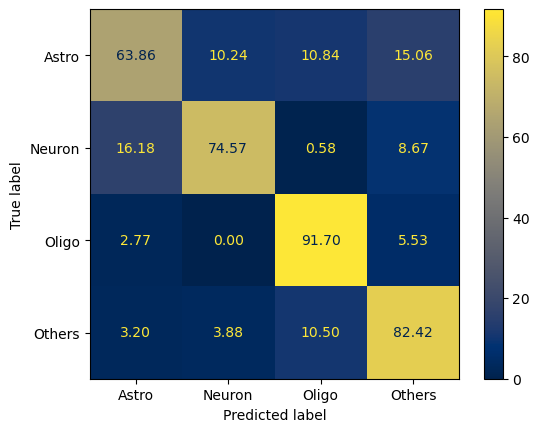

In [36]:
plot = ConfusionMatrixDisplay(final_cm_t,
                              display_labels=['Astro', 'Neuron', 'Oligo', 'Others'])
plot.plot(cmap='cividis', values_format='.2f')         
plt.show()

In [37]:
model = loaded_model
# Confusion matrix across 10 folds, WITH thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reportsT])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reportsT])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reportsT])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reportsT])*100)

Macro avg F1  78.08429242944663
Macro avg F1 std  5.796525516227253
--------------------------
Macro avg precision 79.5193577236758
Macro avg precision std 5.401462319638168
--------------------------
Macro avg recall  78.0432858577745
Macro avg recall std 6.020746713176892


In [38]:
model = loaded_model
# Confusion matrix across 10 folds, WITH NO thresholding 
print('Macro avg F1 ', 
      mean([i['macro avg']['f1-score'] for i in model.cv_reports])*100)
print('Macro avg F1 std ', 
      np.std([i['macro avg']['f1-score'] for i in model.cv_reports])*100)

print("--------------------------")
print('Macro avg precision',
      mean([i['macro avg']['precision'] for i in model.cv_reports])*100)
print('Macro avg precision std',
      np.std([i['macro avg']['precision'] for i in model.cv_reports])*100)
print("--------------------------")
print('Macro avg recall ',
      mean([i['macro avg']['recall'] for i in model.cv_reports])*100)
print('Macro avg recall std',
      np.std([i['macro avg']['recall'] for i in model.cv_reports])*100)

Macro avg F1  75.87650024956385
Macro avg F1 std  6.366637429525143
--------------------------
Macro avg precision 75.45951154467141
Macro avg precision std 6.026858833930817
--------------------------
Macro avg recall  78.14361440199286
Macro avg recall std 6.174268028536992


Plotting feature importance

In [39]:
import seaborn as sns

In [40]:
model_rf = joblib.load('/Users/mokur/OneDrive - University of Cambridge/Attachments/Jan2023/Cell_pipeline/Tuning_parameters/Comparing_methods/BG/bg_prob_linear_SVM_gridSearch.sav')

In [41]:
model_rf.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'selector__n_features_to_select': 28}

In [42]:
#With feature selection
rf_result = model_rf.best_estimator_.named_steps['selector'].get_support(indices=True)
rf_result
rf_result_f = [X_train.columns[i] for i in rf_result]
# (rf_result_f)
importance_all = model_rf.best_estimator_.named_steps['clf'].coef_ # This we get  (n_classes * (n_classes - 1) / 2, n_features) as we have multiple classes
importance_av = np.mean(importance_all,axis=0) # So here, I just took a mean across all class comparisons
f_importance = pd.DataFrame(data={'features':rf_result_f,'importance':importance_av})
f_importance = f_importance.sort_values(by=['importance'],ascending=False)

In [43]:
f_importance_subset = f_importance[0:11]
features = [i.replace('ROI: 0.25 µm per pixel: ','') for i in f_importance_subset['features']]
f_importance_subset = f_importance_subset.copy()
f_importance_subset.loc[:,'features'] = features
f_importance_subset = f_importance_subset.rename(columns={'features':'Feature',
                                    'importance':'Importance'})

In [44]:
f_importance_subset

,Feature,Importance
8,Cell: Length µm,2.632974
11,Cell: Max diameter µm,2.348067
3,Nucleus: Circularity,2.251185
16,Hematoxylin: Nucleus: Max,2.079982
12,Cell: Min diameter µm,1.995359
7,Cell: Area µm^2,1.659368
6,Nucleus: Min diameter µm,1.581863
0,Detection probability,1.499429
23,Hematoxylin: Cell: Mean,1.489024
18,Hematoxylin: Cytoplasm: Mean,1.107245


<Axes: xlabel='Importance', ylabel='Feature'>

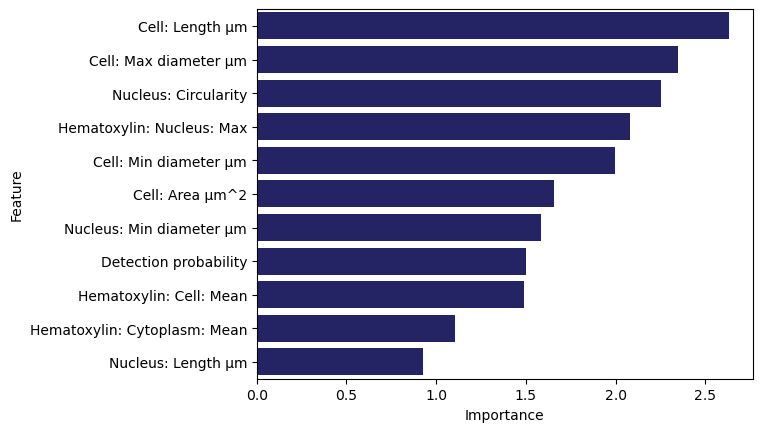

In [45]:
sns.barplot(data=f_importance_subset,
            y="Feature",
            x="Importance",
            color='midnightblue')

In [46]:
keys = ['split0_test_PR_AUC',
        'split1_test_PR_AUC',
        'split2_test_PR_AUC',
        'split3_test_PR_AUC',
        'split4_test_PR_AUC',
        'split5_test_PR_AUC',
        'split6_test_PR_AUC',
        'split7_test_PR_AUC',
        'split8_test_PR_AUC',
        'split9_test_PR_AUC']
pr_val = []
for i in keys:
    pr_val.append(model_rf.cv_results_[i][model_rf.best_index_])

In [47]:
print(model_rf.cv_results_['mean_test_PR_AUC'][model_rf.best_index_]*100)
print('mean pr:', mean(pr_val)*100)
print('std pr:', np.std(pr_val)*100)

82.21941465646822
mean pr: 82.21941465646823
std pr: 6.3150149121223755
